In [858]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense,Dropout,Activation
from keras.optimizers import Adam
from keras.utils import np_utils
import math
import time
import matplotlib.pyplot as plt

In [859]:
# df_all = pd.read_csv('../rnn_data/all/2013_2018_price.csv',encoding='utf-8')
df_all = pd.read_csv('2012_2018_all.csv',encoding='utf-8')
df_c = df_all.groupby('證券代號').get_group('2330')

C:\Users\III\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (5,6,7,8,9,10,25,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [860]:
df_c.columns.values

array(['Unnamed: 0', '三大法人買賣超股數', '外資自營商買賣超股數', '外資自營商買進股數', '外資自營商賣出股數',
       '外資買賣超股數', '外資買進股數', '外資賣出股數', '外陸資買賣超股數(不含外資自營商)',
       '外陸資買進股數(不含外資自營商)', '外陸資賣出股數(不含外資自營商)', '成交筆數', '成交股數', '成交金額',
       '投信買賣超股數', '投信買進股數', '投信賣出股數', '收盤價', '日期', '最低價', '最後揭示買價',
       '最後揭示買量', '最後揭示賣價', '最後揭示賣量', '最高價', '本益比', '漲跌(+/-)', '漲跌價差',
       '自營商買賣超股數', '自營商買賣超股數(自行買賣)', '自營商買賣超股數(避險)', '自營商買進股數',
       '自營商買進股數(自行買賣)', '自營商買進股數(避險)', '自營商賣出股數', '自營商賣出股數(自行買賣)',
       '自營商賣出股數(避險)', '證券代號', '證券名稱', '開盤價'], dtype=object)

In [861]:
# del df_c['三大法人買賣超股數']
del df_c['外資自營商買賣超股數']
del df_c['外資自營商買進股數']
del df_c['外資自營商賣出股數']
del df_c['外資買賣超股數']
del df_c['外資買進股數']
del df_c['外資賣出股數']
del df_c['外陸資買賣超股數(不含外資自營商)']
del df_c['外陸資買進股數(不含外資自營商)']
del df_c['外陸資賣出股數(不含外資自營商)']
del df_c['投信買賣超股數']
del df_c['投信買進股數']
del df_c['投信賣出股數']
del df_c['最後揭示買價']
del df_c['自營商買賣超股數']
del df_c['自營商買賣超股數(自行買賣)']
del df_c['自營商買賣超股數(避險)']
del df_c['自營商買進股數']
del df_c['最後揭示買量']
del df_c['最後揭示賣價']
del df_c['最後揭示賣量']
del df_c['自營商賣出股數']
del df_c['自營商買進股數(避險)']
del df_c['自營商賣出股數(自行買賣)']
del df_c['自營商賣出股數(避險)']
del df_c['自營商買進股數(自行買賣)']
# del df_c['自營商賣出股數(自行買賣)']
# del df_c['自營商賣出股數(避險)']

In [862]:
def batch_data(df_c,time_steps,seperate_rate,BATCH_SIZE):
    del df_c['Unnamed: 0']
    del df_c['證券代號']
    del df_c['本益比']
    del df_c['成交金額']
    del df_c['證券名稱']
    empty_li = df_c[df_c['漲跌(+/-)']=='X'].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['漲跌(+/-)']==' '].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['收盤價']=='X'].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    empty_li = df_c[df_c['收盤價']==' '].index.values
    for i in empty_li:
        df_c = df_c.drop(i)
    
    df_c['成交筆數']=df_c['成交筆數'].str.replace(',','')
    df_c['成交股數']=df_c['成交股數'].str.replace(',','')
    df_c['三大法人買賣超股數']=df_c['三大法人買賣超股數'].str.replace(',','')
    df_c.三大法人買賣超股數 = df_c.三大法人買賣超股數.astype(float)
    df_c.成交筆數 = df_c.成交筆數.astype(float)
    df_c.成交股數 = df_c.成交股數.astype(float)
    df_c.收盤價 = df_c.收盤價.astype(float)
    df_c.最低價 = df_c.最低價.astype(float)
    df_c.最高價 = df_c.最高價.astype(float)
    df_c.開盤價 = df_c.開盤價.astype(float)
    df_c.漲跌價差 = df_c.漲跌價差.astype(float)
    df_c['return'] = np.where(df_c['漲跌(+/-)'] !='+',df_c['漲跌價差']*-1, df_c['漲跌價差'])
    df_c['return']=df_c['return'].shift(-1)
#     df_c['label'] = (df_c['return']+df_c['return'].shift(-4)+df_c['return'].shift(-3)+df_c['return'].shift(-2)+df_c['return'].shift(-1))/df_c['收盤價']*100
    df_c['label'] = df_c['收盤價'].shift(-5)
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    df_c['label']=min_max_scaler.fit_transform(df_c['收盤價'].shift(-5).fillna(0).reshape(-1,1))
    del df_c['漲跌(+/-)']
    del df_c['漲跌價差']
    del df_c['return']
    d= df_c['日期']
    del df_c['日期']
    
    
    
    #remove feature
    del df_c['開盤價']
    
    
    
    print(df_c.columns.values)
    print(df_c.shape)
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    for i in range(len(df_c.columns)-1):
        df_c[df_c.columns[i]] =min_max_scaler.fit_transform(np.array(df_c[df_c.columns[i]]).reshape(-1,1))
    Y_batch = df_c['label']
    del df_c['label']
    X_batch = df_c
    X_batch = np.array(X_batch)
    Y_batch = np.array(Y_batch)
    plt.hist(Y_batch)
    plt.show()
#     Y_batch = np_utils.to_categorical(Y_batch)
    n = len(X_batch)
    drop_n = n%time_steps
    X_batch_t=[]
    Y_batch_t=[]
    for i in range(0,len(X_batch)-time_steps):
        X_batch_t.append(X_batch[i:i+time_steps])
        Y_batch_t.append(Y_batch[i+time_steps])
    train_size = math.ceil(len(X_batch_t)*seperate_rate)
    X_batch_t_train =  X_batch_t[:train_size]
    Y_batch_t_train = Y_batch_t[:train_size]
    X_batch_t_test = X_batch_t[train_size:]
    Y_batch_t_test = Y_batch_t[train_size:]
    X_batch_t_train=np.array(X_batch_t_train)
    Y_batch_t_train=np.array(Y_batch_t_train)
    X_batch_t_test=np.array(X_batch_t_test)
    Y_batch_t_test=np.array(Y_batch_t_test)
    d = d[time_steps:]
    return X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,d

In [863]:
def g_b(X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,BATCH_SIZE):
    X_batch_t_train_b=[]
    Y_batch_t_train_b=[]
    dn= X_batch_t_train.shape[0]%BATCH_SIZE
    print(dn)
    for i in range(dn,X_batch_t_train.shape[0],BATCH_SIZE):
        X_batch_t_train_b.append(X_batch_t_train[i:i+BATCH_SIZE])
        Y_batch_t_train_b.append(Y_batch_t_train[i:i+BATCH_SIZE])
    X_batch_t_train_b=np.array(X_batch_t_train_b)
    Y_batch_t_train_b=np.array(Y_batch_t_train_b)
    X_batch_t_test_b=[]
    Y_batch_t_test_b=[]
    for i in range(0,X_batch_t_test.shape[0],BATCH_SIZE):
        X_batch_t_test_b.append(X_batch_t_test[i:i+BATCH_SIZE])
        Y_batch_t_test_b.append(Y_batch_t_test[i:i+BATCH_SIZE])
    X_batch_t_test_b=np.array(X_batch_t_test_b)
    Y_batch_t_test_b=np.array(Y_batch_t_test_b) 
    return X_batch_t_train_b,Y_batch_t_train_b,X_batch_t_test_b,Y_batch_t_test_b

In [864]:
time_steps=60
seperate_rate=0.7
TIME_STEPS = time_steps
INPUT_SIZE = 6
CELL_SIZE = 3
OUTPUT_SIZE=16
LR = 0.0001

['三大法人買賣超股數' '成交筆數' '成交股數' '收盤價' '最低價' '最高價' 'label']
(1271, 7)


C:\Users\III\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


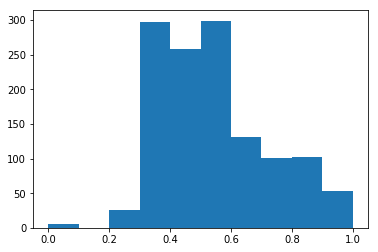

In [865]:
X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,d=batch_data(df_c,time_steps,seperate_rate,BATCH_SIZE)

In [866]:
print(X_batch_t_train.shape,X_batch_t_test.shape)

(848, 60, 6) (363, 60, 6)


In [867]:
BATCH_SIZE=121

#train
X_batch_t_train=X_batch_t_train[1:]
Y_batch_t_train=Y_batch_t_train[1:]
#test
X_batch_t_test=X_batch_t_test[:]
Y_batch_t_test=Y_batch_t_test[:]


In [868]:
X_batch_t_train_b,Y_batch_t_train_b,X_batch_t_test_b,Y_batch_t_test_b=g_b( X_batch_t_train,Y_batch_t_train,X_batch_t_test,Y_batch_t_test,BATCH_SIZE)

0


In [869]:
X_batch_t_test_b.shape

(3, 121, 60, 6)

In [870]:
INPUT_SIZE = 6
CELL_SIZE = 30
OUTPUT_SIZE=16
LR = 0.0001*0.7

In [871]:
model =Sequential()
model.add(LSTM(
    batch_input_shape=(BATCH_SIZE,TIME_STEPS, INPUT_SIZE),
    output_dim=8,
    return_sequences=False,
    stateful=True,
))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Dense(1))
adam = Adam(LR)
model.compile(optimizer=adam,
              loss='mse')

C:\Users\III\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(batch_input_shape=(121, 60, ..., return_sequences=False, stateful=True, units=8)`
  


In [872]:
X_batch_t_train_b[0].shape

(121, 60, 6)

In [873]:
epoch = 1001
cl = []
start_time = time.time()
cl_chart=[]
for epoch in range(epoch):
    for i in range(X_batch_t_train_b.shape[0]):
#         print(X.shape)
        X = X_batch_t_train_b[i].reshape(BATCH_SIZE,TIME_STEPS,INPUT_SIZE)
        Y = Y_batch_t_train_b[i].reshape(BATCH_SIZE,1)
        cost = model.train_on_batch(X,Y)
#         pred = model.predict_class(X,Y)
#         pred = model.predict(X, 1)
#         cl_chart.append(cost)
#         if cost<20:
#             cl.append(cost)
        cl.append(cost)
    if epoch % 100  == 0:
        print('cl',np.average(cl))
        
        print('train cost: ', cost,'epoch: ',epoch)
#         print('class',pred)
        cl=[]
t=(start_time-time.time())*-1
print('耗時:'+str(t)+'s')

cl 0.293151
train cost:  0.150416 epoch:  0
cl 0.153828
train cost:  0.0588761 epoch:  100
cl 0.0572132
train cost:  0.0293762 epoch:  200
cl 0.0283978
train cost:  0.0282587 epoch:  300
cl 0.0165078
train cost:  0.0206931 epoch:  400
cl 0.0103666
train cost:  0.0143284 epoch:  500
cl 0.00688524
train cost:  0.010917 epoch:  600
cl 0.00481293
train cost:  0.00738342 epoch:  700
cl 0.00354704
train cost:  0.0055516 epoch:  800
cl 0.00278279
train cost:  0.00439084 epoch:  900
cl 0.00233193
train cost:  0.00401002 epoch:  1000
耗時:97.69547748565674s


In [874]:
yhat=[]
for i in range(len(X_batch_t_test_b)):
    yhat.append(model.predict_on_batch((X_batch_t_test_b[i])))

In [875]:
Y_batch_t_test[-5]=Y_batch_t_test[-6]
Y_batch_t_test[-4]=Y_batch_t_test[-6]
Y_batch_t_test[-3]=Y_batch_t_test[-6]
Y_batch_t_test[-2]=Y_batch_t_test[-6]
Y_batch_t_test[-1]=Y_batch_t_test[-6]

In [876]:
np.average((yhat-Y_batch_t_test)**2)

0.019642406393419101

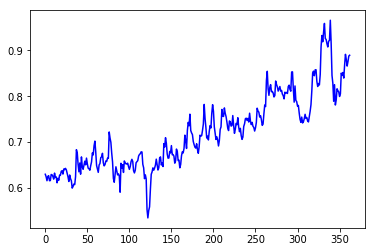

In [877]:
yhat=np.array(yhat).flatten()
plt.plot(yhat,color='blue')
plt.show()

In [878]:
np.average(Y_batch_t_test)

0.78193935251351521

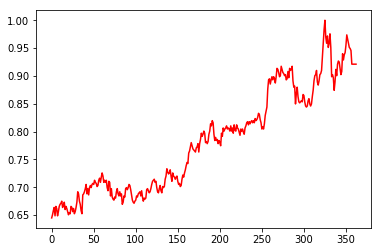

In [879]:
plt.plot(Y_batch_t_test,color='red')
plt.show()

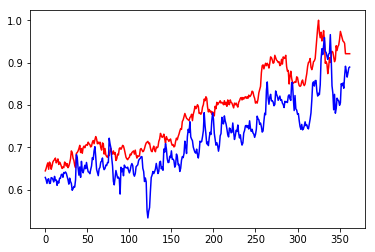

In [880]:
plt.plot(Y_batch_t_test,color='red')
plt.plot(yhat,color='blue')
plt.show()

In [881]:
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x=np.array(min_max_scaler.fit_transform(df_c['收盤價'].fillna(0).reshape(-1,1))).astype('float')

C:\Users\III\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\III\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [882]:
x1=x[-363:]

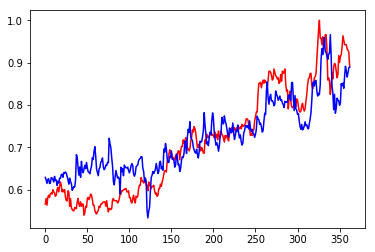

In [883]:
plt.plot(x1,color='red')
plt.plot(yhat,color='blue')
plt.show()